# COMPAS CLUE test + feature extraction


In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

## choose dset

In [1]:
CSV_PATH = "./../data/"
save_dir = "/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/regression/mimic_mortability_prediction/bnn/state_dicts.pkl"

cuda = False
device: str = "cuda" if cuda else "cpu"
learning_rate = 1e-2

In [2]:
INPUT_DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 41]

In [3]:
from counterfactual_xai.utils.mimic_dataloader import MimiDataLoader
from counterfactual_xai.utils.datafeed import DataFeed
from counterfactual_xai.utils.clue.bnn.mlp import MLP

# INPUT_DIMS = [1, 1, 8, 2]
# INPUT_DIMS = [5, 5, 41, 10]
# INPUT_DIMs bestehen aus 18 einzelnen Kategorien (hadm_id, age, max_hours, etc.) 2 one-hot Kategorien (gender_F, gender_M) und 41 one-hot Kategorien (ethnicity)
# INPUT_DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 41]

x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds, DATA_KEYS, input_dims = MimiDataLoader(INPUT_DIMS,
                                                                                                           CSV_PATH).get_mimic_dataset()

trainset = DataFeed(x_train, y_train, transform=None)
valset = DataFeed(x_test, y_test, transform=None)

input_dim = x_train.shape[1]
width = 200
depth = 2
output_dim = y_train.shape[1]

mlp = MLP(input_dim, width, depth, output_dim, flatten_image=False)
print(mlp.eval())

MLP(
  (block): Sequential(
    (0): Linear(in_features=59, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


### BNN LOADING


In [4]:
from counterfactual_xai.utils.clue.bnn.gaussian_bnn import BNNCategorical

N_train = x_train.shape[0]

bnn_cat = BNNCategorical(mlp, N_train, lr=learning_rate, cuda=cuda)
bnn_cat.load_weights(save_dir)

    Total params: 0.05M


### VAE

In [7]:
from counterfactual_xai.utils.clue.vae.gaussian_vae import GaussianVAE

width = 300
depth = 3
latent_dim = 4

lr = 1e-4
VAE = GaussianVAE(INPUT_DIMS, width, depth, latent_dim, pred_sig=False,
                  lr=lr, cuda=cuda, flatten=False)

VAE.load(
    filename="/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/regression/mimic_mortability_prediction/vae/saves/fc_preact_VAE_d2_lsat_models_4/_models/theta_best.dat",
    device=device)


INFO:root:Loading: /Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/regression/mimic_mortability_prediction/vae/saves/fc_preact_VAE_d2_lsat_models_4/_models/theta_best.dat


    Total params: 0.40M
  restoring epoch: 707, lr: 0.000100


707

### map to latent space + get uncertainties

In [8]:
from counterfactual_xai.methods.interpretation import latent_project_gauss, latent_project_cat

tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = \
    latent_project_cat(bnn_cat, VAE, dset=trainset, batch_size=2048, cuda=cuda)
tr_uncertainty_vec = tr_aleatoric_vec + tr_epistemic_vec

te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = \
    latent_project_cat(bnn_cat, VAE, dset=valset, batch_size=2048, cuda=cuda)

te_uncertainty_vec = te_aleatoric_vec + te_epistemic_vec

uncertainty_idxs_sorted = np.flipud(np.argsort(te_uncertainty_vec))
aleatoric_idxs_sorted = np.flipud(np.argsort(te_aleatoric_vec))
epistemic_idxs_sorted = np.flipud(np.argsort(te_epistemic_vec))

plt.figure(dpi=80)
plt.hist(te_uncertainty_vec, density=True, alpha=0.5)
plt.hist(tr_uncertainty_vec, density=True, alpha=0.5)
plt.legend(['test', 'train'])
plt.ylabel('Uncertainty')
plt.show()

DEBUG:matplotlib:matplotlib data path: /Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/lukasscholz/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/lukasscholz/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/lukasscholz/.matplotlib/fontlist-v330.json


RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for block.4.weight: copying a param with shape torch.Size([2, 200]) from checkpoint, the shape in current model is torch.Size([1, 200]).
	size mismatch for block.4.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

### Overview uncertainty histogram per dataset dimension


In [ ]:
dname = "mimic"
# var_names = {"mimic": ['LSAT', 'UGPA', 'race', 'sex']}
var_names_flat = {
    "mimic": ["age", "max_hours", "vent", "vaso", "adenosine", "dobutamine", "dopamine",
              "epinephrine", "isuprel",
              "milrinone", "norepinephrine", "phenylephrine", "vasopressin", "colloid_bolus", "crystalloid_bolus",
              "nivdurations", "gender_F",
              "gender_M", "ethnicity_AMERICAN INDIAN/ALASKA NATIVE",
              "ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE",
              "ethnicity_ASIAN", "ethnicity_ASIAN - ASIAN INDIAN", "ethnicity_ASIAN - CAMBODIAN",
              "ethnicity_ASIAN - CHINESE",
              "ethnicity_ASIAN - FILIPINO", "ethnicity_ASIAN - JAPANESE", "ethnicity_ASIAN - KOREAN",
              "ethnicity_ASIAN - OTHER",
              "ethnicity_ASIAN - THAI", "ethnicity_ASIAN - VIETNAMESE", "ethnicity_BLACK/AFRICAN",
              "ethnicity_BLACK/AFRICAN AMERICAN",
              "ethnicity_BLACK/CAPE VERDEAN", "ethnicity_BLACK/HAITIAN", "ethnicity_CARIBBEAN ISLAND",
              "ethnicity_HISPANIC OR LATINO",
              "ethnicity_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)", "ethnicity_HISPANIC/LATINO - COLOMBIAN",
              "ethnicity_HISPANIC/LATINO - CUBAN",
              "ethnicity_HISPANIC/LATINO - DOMINICAN", "ethnicity_HISPANIC/LATINO - GUATEMALAN",
              "ethnicity_HISPANIC/LATINO - HONDURAN",
              "ethnicity_HISPANIC/LATINO - MEXICAN", "ethnicity_HISPANIC/LATINO - PUERTO RICAN",
              "ethnicity_HISPANIC/LATINO - SALVADORAN",
              "ethnicity_MIDDLE EASTERN", "ethnicity_MULTI RACE ETHNICITY",
              "ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER",
              "ethnicity_OTHER", "ethnicity_PATIENT DECLINED TO ANSWER", "ethnicity_PORTUGUESE",
              "ethnicity_SOUTH AMERICAN",
              "ethnicity_UNABLE TO OBTAIN", "ethnicity_UNKNOWN/NOT SPECIFIED", "ethnicity_WHITE",
              "ethnicity_WHITE - BRAZILIAN",
              "ethnicity_WHITE - EASTERN EUROPEAN", "ethnicity_WHITE - OTHER EUROPEAN", "ethnicity_WHITE - RUSSIAN"]
}

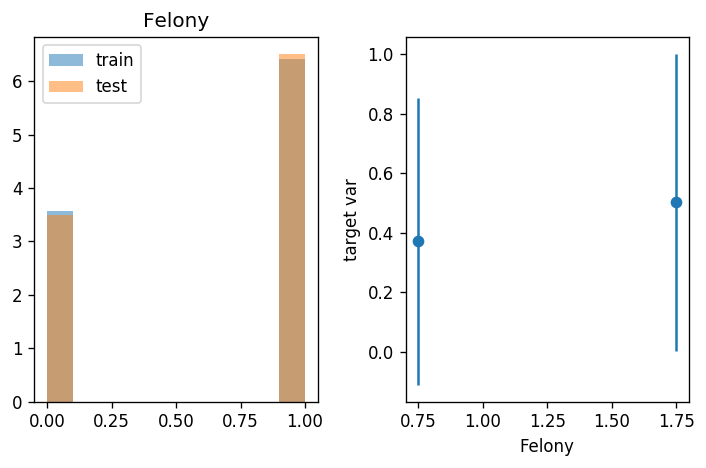

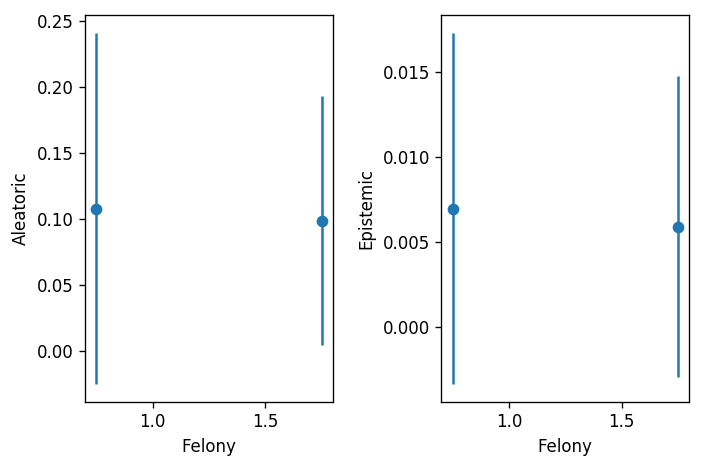

In [21]:

var_N = 11

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].hist(x_train[:, var_N], density=True, alpha=0.5)
axes[0].hist(x_test[:, var_N], density=True, alpha=0.5)
axes[0].legend(['train', 'test'])
axes[0].set_title(var_names_flat[dname][var_N])

bins = [-5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5]
center_bins = ((np.array([0] + bins) + np.array(bins + [0])) / 2)[1:]
center_bins[-1] = bins[-1]

bin_idx = np.digitize(x_train[:, var_N], bins, right=False)
bin_means = []
bin_stds = []
aleatoric_mean = []
aleatoric_stds = []
epistemic_mean = []
epistemic_stds = []

for n_bin, bin_start in enumerate(bins):
    y_select = y_train[bin_idx == n_bin]
    aleatoric_select = tr_aleatoric_vec[bin_idx == n_bin]
    epistemic_select = tr_epistemic_vec[bin_idx == n_bin]
    if len(y_select) == 0:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)
        aleatoric_mean.append(np.nan)
        aleatoric_stds.append(np.nan)
        epistemic_mean.append(np.nan)
        epistemic_stds.append(np.nan)
    else:
        bin_means.append(y_select.mean())
        bin_stds.append(y_select.std())
        aleatoric_mean.append(aleatoric_select.mean())
        aleatoric_stds.append(aleatoric_select.std())
        epistemic_mean.append(epistemic_select.mean())
        epistemic_stds.append(epistemic_select.std())

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, bin_means, yerr=bin_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('target var')

plt.tight_layout()

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].errorbar(center_bins, aleatoric_mean, yerr=aleatoric_stds, fmt='o')
axes[0].set_xlabel(var_names_flat[dname][var_N])
axes[0].set_ylabel('Aleatoric')
# plt.show()

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, epistemic_mean, yerr=epistemic_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('Epistemic')

plt.tight_layout()
# plt.show()



# CLUE

In [23]:
use_index = uncertainty_idxs_sorted

Nbatch = 512
z_init_batch = z_test[use_index[:Nbatch]]
x_init_batch = x_test[use_index[:Nbatch]]
y_init_batch = y_test[use_index[:Nbatch]]




## Run base CLUE


In [17]:
import torch
from counterfactual_xai.methods.clue import decompose_std_gauss, decompose_entropy_cat, CLUE
from counterfactual_xai.methods.utils import LnDistance

dist = LnDistance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]

aleatoric_weight = 0
epistemic_weight = 0
uncertainty_weight = 1

distance_weight = 2 / x_dim
prediction_similarity_weight = 0

print("Bottom")
o_preds = bnn_cat.sample_predict(x_init_batch, Nsamples=0, grad=False)
o_uncert, o_aleatoric, o_epistemic = decompose_entropy_cat(o_preds)
desired_preds = o_preds.mean(dim=0).cpu().numpy()

CLUE_explainer = CLUE(VAE, bnn_cat, x_init_batch, uncertainty_weight=uncertainty_weight,
                      aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                      prior_weight=0, distance_weight=distance_weight,
                      latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                      lr=1e-2, desired_preds=None, cond_mask=None, distance_metric=dist,
                      z_init=z_init_batch, norm_MNIST=False,
                      flatten_BNN=False, regression=regression_bools[names.index(dname)], cuda=True)

torch.autograd.set_detect_anomaly(False)

z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
    min_steps=3, max_steps=50,
    n_early_stop=3)

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


Bottom


"\nCLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=uncertainty_weight, aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,\n                      prior_weight=0, distance_weight=distance_weight,\n                 latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,\n                 lr=1e-2, desired_preds=None, cond_mask=None, distance_metric=dist,\n                 z_init=z_init_batch, norm_MNIST=False,\n                 flatten_BNN=False, regression=regression_bools[names.index(dname)], cuda=True)\n\ntorch.autograd.set_detect_anomaly(False)\n\nz_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(\n                                                        min_steps=3, max_steps=50,\n                                                        n_early_stop=3)\n\nfig, axes = plt.subplots(1, 3, dpi=130)\naxes[0].plot(cost_vec.mean(axis=1))\naxes[0].set_title('mean Cost')\naxes[0].se

## Plot histograms


In [18]:
preds = bnn_cat.sample_predict(x_vec[-1], Nsamples=0, grad=False)
post_uncert, post_aleatoric, post_epistemic = decompose_entropy_cat(preds)
post_preds = preds.mean(dim=0).cpu().numpy()[:, 1]

fig, axes = plt.subplots(1, 3, dpi=180)

axes[0].hist(post_uncert.cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[0].hist(te_uncertainty_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[0].set_title('All uncertainty')
axes[0].legend()

axes[1].hist(post_aleatoric.cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[1].hist(te_aleatoric_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[1].set_title('Aleatoric')
axes[1].legend()

axes[2].hist(post_epistemic.cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[2].hist(te_epistemic_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[2].set_title('Epistemic')
axes[2].legend()

plt.tight_layout()

Bottom


"fig, axes = plt.subplots(1, 3, dpi=180)\n    \n\naxes[0].hist(post_uncert.cpu().numpy(), density=True, alpha=0.5, label='CLUE')\naxes[0].hist(te_uncertainty_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')\naxes[0].set_title('All uncertainty')\naxes[0].legend()\n\naxes[1].hist(post_aleatoric.cpu().numpy(), density=True, alpha=0.5, label='CLUE')\naxes[1].hist(te_aleatoric_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')\naxes[1].set_title('Aleatoric')\naxes[1].legend()\n\naxes[2].hist(post_epistemic.cpu().numpy(), density=True, alpha=0.5, label='CLUE')\naxes[2].hist(te_epistemic_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')\naxes[2].set_title('Epistemic')\naxes[2].legend()\n\nplt.tight_layout()"

('o pred; ', 0.8571318, 'pred; ', 0.93803585)


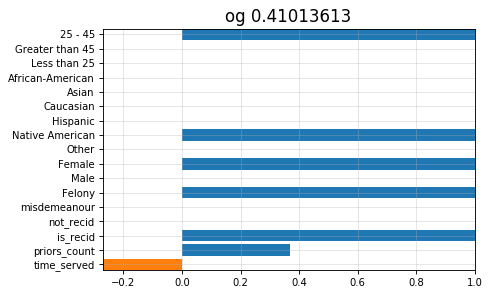

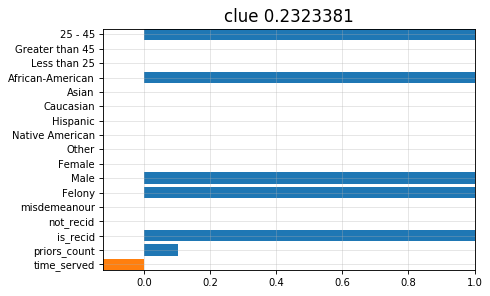

In [45]:
from counterfactual_xai.methods.interpretation import gen_bar_plot

Nsample = 1

print('o pred; ', desired_preds[Nsample, 1], 'pred; ', post_preds[Nsample])

gen_bar_plot(var_names_flat[dname], x_init_batch[Nsample], title='og ' + str(te_uncertainty_vec[use_index[Nsample]]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=40, fs=9, verbose=False, sort=False, dpi=80, neg_color=True, ax=None, c=None)

# gen_bar_plot(var_names_flat[dname], x_vec[0,Nsample,:], title='vae ' + str(uncertainty_vec[0,Nsample]), xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
#                  max_fields=40, fs=9, verbose=False, sort=False, dpi=80, neg_color=True, ax=None, c=None)

gen_bar_plot(var_names_flat[dname], x_vec[-1, Nsample, :], title='clue ' + str(post_uncert.cpu().numpy()[Nsample]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=40, fs=9, verbose=False, sort=False, dpi=80, neg_color=True, ax=None, c=None)


